In [ ]:
!pip install lightgbm catboost xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


KSDRM (KNN, SVM, DT, RF, MLP) with Logistic Regression as meta learner

Train shape: (175341, 45)
Test shape: (82332, 45)
🔹 Training knn...
🔹 Training svm...
🔹 Training dt...
🔹 Training rf...
🔹 Training mlp...
✅ Accuracy: 0.9487920830503541

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     18600
           1       0.96      0.96      0.96     32935

    accuracy                           0.95     51535
   macro avg       0.94      0.95      0.94     51535
weighted avg       0.95      0.95      0.95     51535



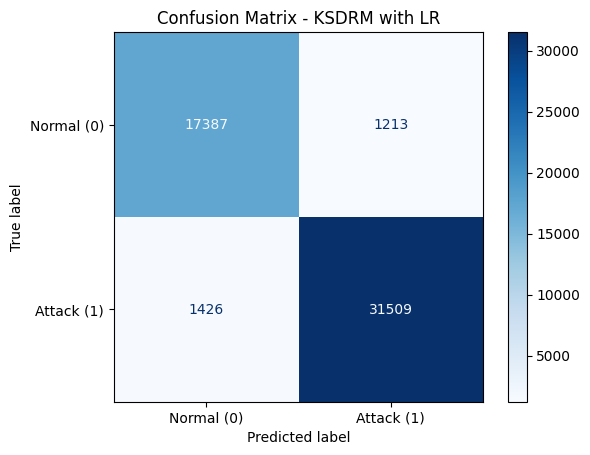

In [ ]:
# ================================
# KSDRM (KNN, SVM, DT, RF, MLP) with Logistic Regression
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# -------------------------------
# Step 1: Load Data
# -------------------------------
train = pd.read_csv("UNSW_NB15_training-set.csv")
test = pd.read_csv("UNSW_NB15_testing-set.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# -------------------------------
# Step 2: Drop leakage/ID + attack_cat
# -------------------------------
drop_cols = ['id', 'attack_cat']  # ensure attack_cat removed
train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

# -------------------------------
# Step 3: Preprocessing
# -------------------------------
# Fill missing values
train = train.fillna(0)
test = test.fillna(0)

# Encode categorical columns
cat_cols = ['proto', 'service', 'state']
le = {}
for col in cat_cols:
    le[col] = LabelEncoder()
    all_vals = pd.concat([train[col], test[col]], axis=0)
    le[col].fit(all_vals.astype(str))
    train[col] = le[col].transform(train[col].astype(str))
    test[col] = le[col].transform(test[col].astype(str))

# -------------------------------
# Step 4: Features & Target
# -------------------------------
X = pd.concat([train.drop(columns=['label']), test.drop(columns=['label'])], axis=0)
y = pd.concat([train['label'], test['label']], axis=0)   # ✅ only use numeric labels

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# Step 5: Define Base Learners
# -------------------------------
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ('svm', SVC(probability=True, kernel='rbf', random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=20, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, n_jobs=-1, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
]

# -------------------------------
# Step 6: Custom Stacking
# -------------------------------
stack_train = np.zeros((X_train.shape[0], len(base_learners)))
stack_test = np.zeros((X_test.shape[0], len(base_learners)))

for i, (name, model) in enumerate(base_learners):
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)
    stack_train[:, i] = model.predict(X_train)
    stack_test[:, i] = model.predict(X_test)

# -------------------------------
# Step 7: Meta Learner (Logistic Regression)
# -------------------------------
meta_learner = LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42)
meta_learner.fit(stack_train, y_train)
y_pred = meta_learner.predict(stack_test)

# -------------------------------
# Step 8: Evaluation
# -------------------------------
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Attack (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KSDRM with LR")
plt.show()


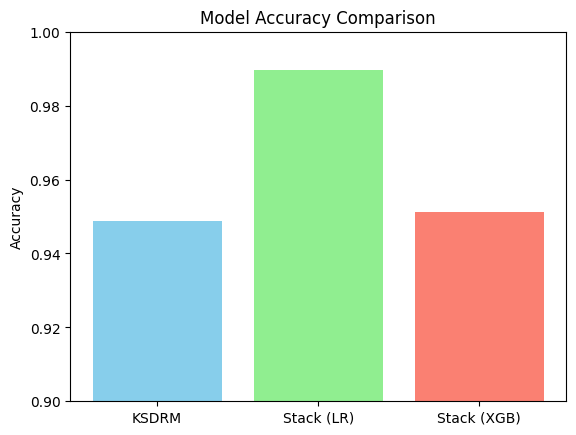

In [ ]:
import matplotlib.pyplot as plt

models = ["KSDRM", "Stack (LR)", "Stack (XGB)"]
accuracy = [0.9488, 0.9895, 0.9512]

plt.bar(models, accuracy, color=["skyblue", "lightgreen", "salmon"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.9, 1.0)
plt.show()


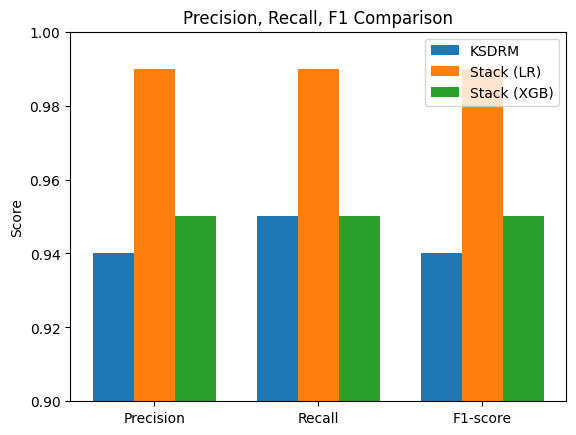

In [ ]:
import numpy as np

metrics = ["Precision", "Recall", "F1-score"]
ksdrm = [0.94, 0.95, 0.94]
stack_lr = [0.99, 0.99, 0.99]
stack_xgb = [0.95, 0.95, 0.95]

x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, ksdrm, width, label="KSDRM")
plt.bar(x, stack_lr, width, label="Stack (LR)")
plt.bar(x + width, stack_xgb, width, label="Stack (XGB)")

plt.xticks(x, metrics)
plt.ylim(0.9, 1.0)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Comparison")
plt.legend()
plt.show()
